# Aim
Creating **vision transformer (ViT)** from scratch and test it on a **FoodVision** problem.

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary

import matplotlib.pyplot as plt
from pathlib import Path
import random
from PIL import Image
import numpy as np

# custom functions
from turning_modular import data_setup, engine

In [4]:
# device agnotic code
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# 1. Get data

In [8]:
# data path
data_path = Path("../Dataset/")

# image path
img_path = data_path / "pizza_steak_sushi"

if img_path.is_dir():
    print("Folder already exists, skipping download ...")
else:
    print("Folder doesn't exist, creating one ...")
    
    # create image folder
    img_path.mkdir(parents=True)

    # download the data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data ...")

        # write data
        f.write(request.content)

    # extract zip file
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as f:
        print("Unzipping the file ...")

        # extract file
        f.extractall(img_path)

    # delete zipfile
    os.remove(data_path / "pizza_steak_sushi.zip")

Folder already exists, skipping download ...


In [9]:
# training data directory
train_dir = img_path / "train"

# testing data directory
test_dir = img_path / "test"

### visualise a random image

Image class pizza.
Image height 512.
Image width 512.


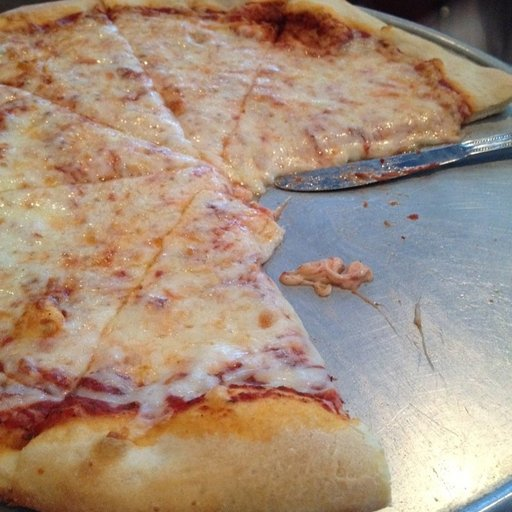

In [5]:
rdn_img_path = random.choice(list(train_dir.glob("*/*.jpg")))

# get the img from path
img = Image.open(rdn_img_path)

# class of the img
img_class = rdn_img_path.parent.stem

# img metadata
print(f"Image class {img_class}.")
print(f"Image height {img.height}.")
print(f"Image width {img.width}.")

img

# 2. Create datasets and dataloaders
The catch size used is 4096. But due to computational difficulty we are going to use 64 to fit the GPU memory hassle free.

### a. create a transformer
The image size mentioned in the paper is **(224,224)**.

In [6]:
img_size = 224

custom_transform = transforms.Compose([transforms.Resize(size=(img_size,img_size)),
                                       transforms.ToTensor()])
custom_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [7]:
batch_size = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataset_dataloader(train_dir=train_dir, test_dir= test_dir,
                                                                                      transform=custom_transform, batch_size=batch_size,
                                                                                     n_workers=0)

(torch.Size([3, 224, 224]), tensor(0))

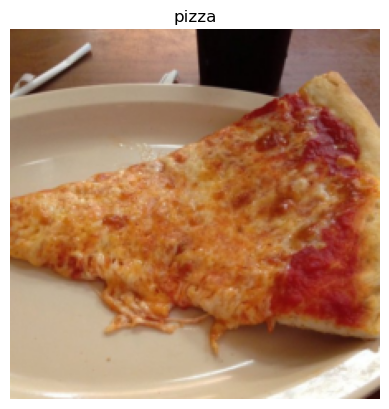

In [8]:
img_batch, lb_batch = next(iter(train_dataloader))

img, lb = img_batch[5], lb_batch[5]

plt.imshow(img.permute(1,2,0))
plt.title(class_names[lb])
plt.axis("off")
img.shape, lb

# 3. ViT Architecture
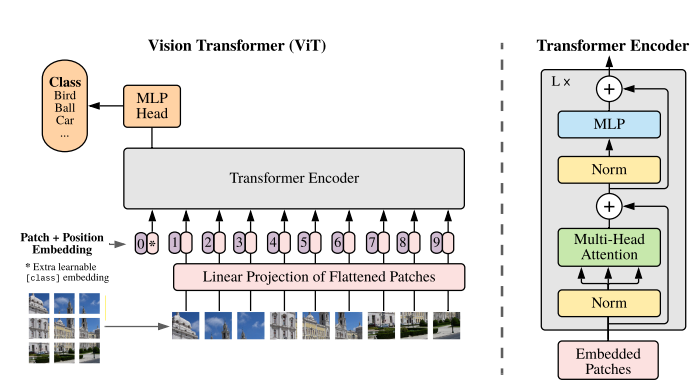

1. Patch + position - Turns images into a sequence of image patches and adds a position number to specify the order in which the patches needs to come
2. Linear projection of flattened patches (embedded patches) - img patches turned into embedding inorder to make it learnable.
3. Norm - Layer normalisation
4. MLP -  refer to any collection of feedforward layers, that is collection of layers with `forward()` method. The forward contains two linear and a `GeLU` layer inbetween and a `dropout` layer.
5. Transformer encoder - it is a collection of layers listed above. It contains two skip connections insider the encoder (+ symbol) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The oarchitecture is comprised of a number of transformer enocders stacked on top of eachotehr.
6. MLP head - It is the output layer of the architecture. Since we are performing classification, it is a `classifier head`

The four main equations are,

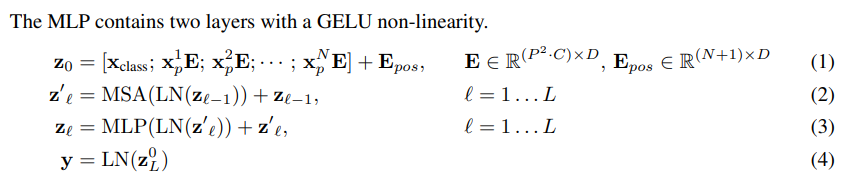

1. 1st equation - Deals with class token, patch embedding and position embedding of input image.
2. 2nd equation - Says that a Multi-head attention layer(MSA) is wrapping a LayerNorm layer (LN). The additon at the end is adding the input to the output and forming a skip resiudual connection. The advatage of performing this is to avoid the weight values from getting very small, therefore will be able to perform deeper netwoeks from getting `null`.
3. Says taht for every layer there is also a multilayer percepotron wrapping the LN. It is added with output of MSA block
4. Output is the zero index value of LN wrapped from output of MLP block

In our case, we are going to perform `ViT-Base` which contains,
1. layers - 12 transformer encoder blocks
2. hidden size - 768 embedding dimension that is how our image gets transformed (patch)
3. MLP size - 3072 number of hidden units in hte MLP layer
4. head - 12 head in the multi-head attention layer
5. params - 86 million parameters in the model

### a. Equation 1: Data into patches and creating class, position and patch embedding
We need to create,
* Patch embedding
* Class token embedding
* Position embedding

##### i. Patch embedding
Converting image into patches and embed those patches. We saw that embedding in learnable represntation (numerical representation) ~of some form and is oftern a vector.

Convert image into patches and embed each patch and represent each patch in a column $$**(H,W,C) -> (N_{patches}, P^2\dot C)**$$
The patch size used according to the paper is 16 as it is the best performing version of ViT-Base (refere table 6). The number of pathces is computed by, $N = \frac{H\times W}{P^2} = \frac{(224\times 224)}{16^2}$
$$(224,224,3) -> (196, 768)$$

In [9]:
# CREATE NUMBER OF PATCHES

height = 224 # height
width  = 224 # width
C      = 3   # channels
patch_size = 16

# number of patches
N = int((height * width)/(patch_size**2))

print(f"The image of size of ({height},{width}) with patch size {patch_size} has {N} patches.")

The image of size of (224,224) with patch size 16 has 196 patches.


In [10]:
# CREATE NUMBER OF OUTPUT EMBEDDING REQUIRED

# size of embedding
embedding_size = patch_size**2 * C
embedding_size

768

Patch size 16 X 16 with 14 patches


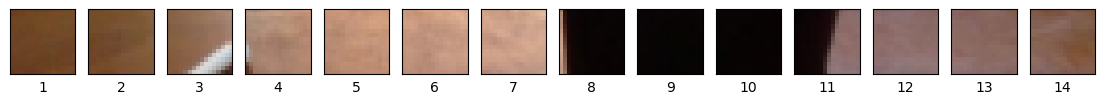

In [11]:
# SINGLE IMAGE PATCH TO PATCHES

# permuted image
perm_img = img.permute(1,2,0)

# number of patches
num_patch = int(np.ceil(height/patch_size))

# plotting
fig, ax = plt.subplots(nrows=1, ncols=num_patch,
                       figsize = (num_patch, num_patch),
                       sharex=True, sharey=True)

for i, patch in enumerate(range(0, height, patch_size)):
    ax[i].imshow(perm_img[:patch_size, patch:patch+patch_size, :])
    ax[i].set_xlabel(i+1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

print(f"Patch size {patch_size} X {patch_size} with {num_patch} patches")

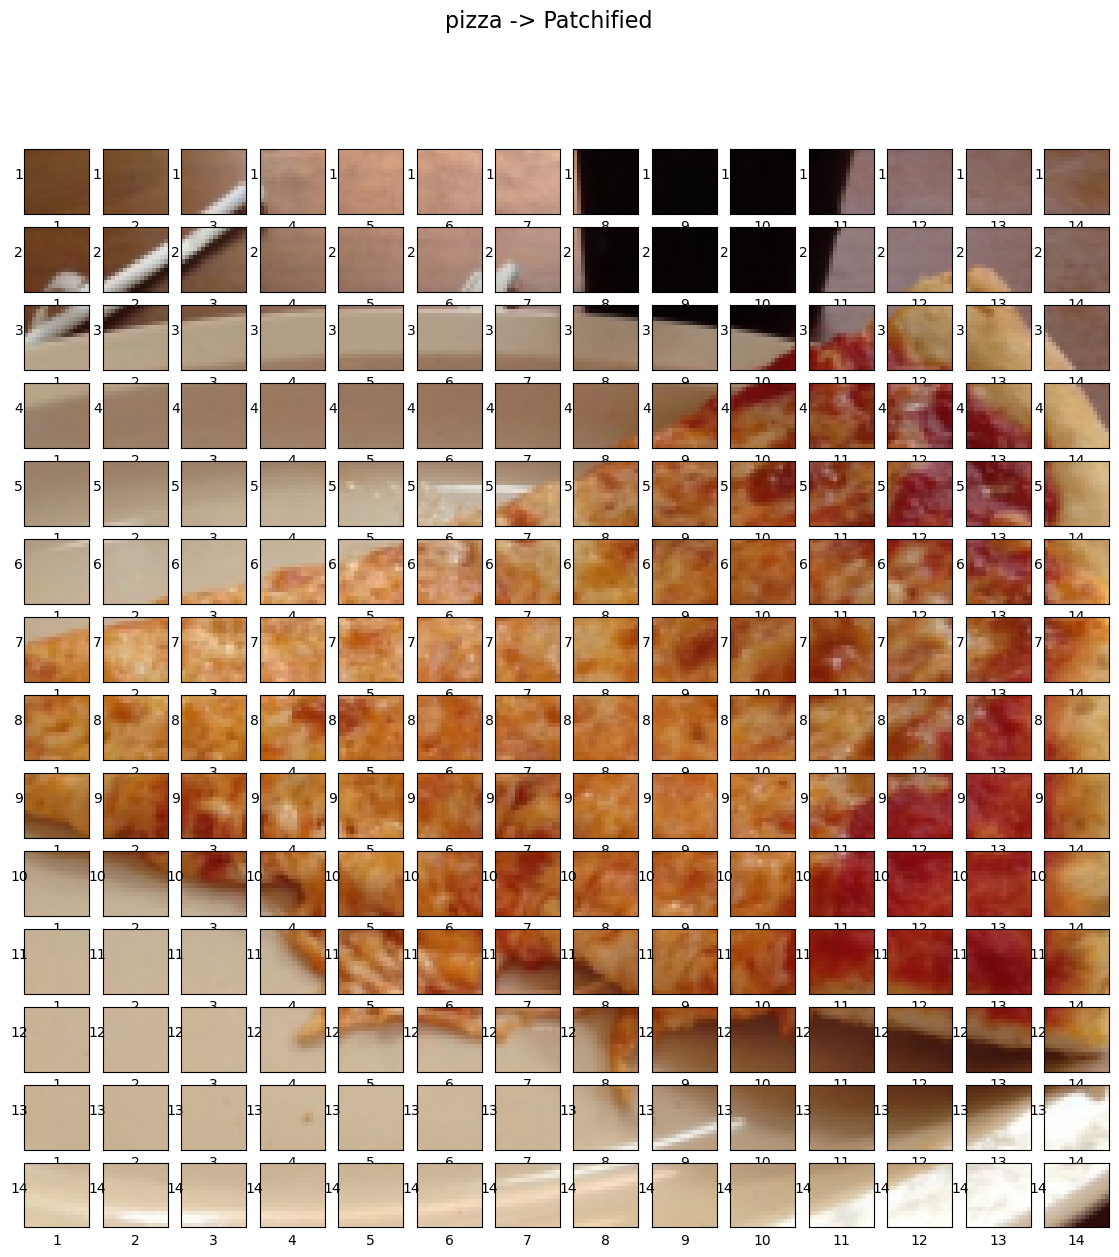

In [12]:
# WHOLE IMAGE TO PATCHES

# plotting
fig, ax = plt.subplots(nrows=num_patch, ncols=num_patch,
                       figsize = (num_patch, num_patch),
                       sharex=True, sharey=True)

for i, patch_height in enumerate(range(0, height, patch_size)):
    for j, patch_width in enumerate(range(0, width, patch_size)):
        ax[i,j].imshow(perm_img[patch_height:patch_size+patch_height, 
                       patch_width:patch_size+patch_width, :])
        ax[i,j].set_ylabel(i+1, rotation="horizontal")
        ax[i,j].set_xlabel(j+1)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

fig.suptitle(f"{class_names[lb]} -> Patchified", fontsize=16)
plt.show()

Patching of entire image

can be done by using nn.Conv2d and set the kernel size and stride = patch size to get a layer that split splits images to patches and creates a learnable embedding

In [13]:
from torch import nn

conv2d = nn.Conv2d(in_channels = C,
                   out_channels= embedding_size,
                   kernel_size=patch_size,
                   stride = patch_size,
                   padding= 0)

In [14]:
# convolved image
conv_img = conv2d(img.unsqueeze(0)) # patchign and embedding

# flatten th3e 3rd and 4th dimesnion to a single vector of n_patches
flatten = nn.Flatten(start_dim=2, end_dim=3)
flatten_img = flatten(conv_img)

img.shape, conv_img.shape, flatten_img.shape

(torch.Size([3, 224, 224]),
 torch.Size([1, 768, 14, 14]),
 torch.Size([1, 768, 196]))

In [15]:
# permute the 2nd and 3rd dimension
img_conv_flat = flatten_img.permute(0,2,1)
img_conv_flat.shape

torch.Size([1, 196, 768])

The original transformer was intended for text, thats why we are transforming the image like a 1D text in a 1D space.

In [30]:
# patching as a class
from ViTModules import convFlat

patchify = convFlat.patchEmbed(in_channels=3, embed_dim=embedding_size,
                               patch_size=patch_size)

embed_img = patchify(img.unsqueeze(0))

embed_img.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


torch.Size([1, 196, 768])

In [31]:
summary(patchify, input_shape = [3,224,224])

Layer (type:depth-idx)                   Param #
patchEmbed                               --
├─Conv2d: 1-1                            590,592
├─Flatten: 1-2                           --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0

##### 2. Creating class token embedding
The output of this serves as the image representation

In [35]:
batch_size = embed_img.shape[0]

# create class token embedding as a learnable parameter of shape (1 X D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_size),
                           requires_grad=True)

# prepend class embedding with patch embedding
embed_img_class_embed = torch.cat((class_token, embed_img), dim=1)

embed_img_class_embed.shape

torch.Size([1, 197, 768])

##### 3. position embedding

Give positions to each value in the embedding. By knwoing the position, the architecture knows the order the patch comes in (it should be in correct order).

From equation 1, we saw that the shape of position embedding should be (N+1 X D) that is for all the values

In [43]:
#position embedding
pos_embed = nn.Parameter(torch.randn(1, N+1, embedding_size),
                         requires_grad=True)

# add position embedding
embed_class_pos_img = embed_img_class_embed + pos_embed

embed_class_pos_img.shape

torch.Size([1, 197, 768])

### b. Equation2: Multi-head attention (MSA)

from equation 2, we need to perform,
1. Norm
2. MSA
3. Resiual connection - add inputs to the output

##### 1. Norm
layer norm helps improving training time and improve generalisation. It makes data into  similar distribution, so the optimisation function will be a circle rather than elongated towards the higher scaled value.

In [44]:
layer_norm = nn.LayerNorm(normalized_shape=embedding_size)

##### 2. MSA
it is self-attention applied multiple times. It takes a sequence of words and then calculates which word should pay more attention to another word. In our case of images, it will calculate which patch is more related to another patch.

In our case we use triple embedding **query, key, value or qkv** which is three versions of the layer normalised patched image.

In [53]:
MSA = nn.MultiheadAttention(embed_dim=embedding_size,
                            num_heads= =12, # parallel
                            dropout=0, # no dropout is given
                            batch_first=True)

atten_output, _ = MSA(query = embed_class_pos_img,
                      key = embed_class_pos_img,
                      value = embed_class_pos_img,
                      need_weights = False) # require weights or only layer output

In [67]:
# class for MSA block
from ViTModules import MSA

MSA_block = MSA.MSABlock(embed_dim=embedding_size, 
                               num_heads=12, # from table 1
                              atten_drop=False)

img_through_MSA = MSA_block(embed_class_pos_img)

img_through_MSA.shape # the shape remains same not the data

torch.Size([1, 197, 768])

### 3. Equation3: Multilayer Perceptron (MLP)

The MLP contains, 
1. Two linear layers
2. One GeLU activation layer
3. Dropout at the end of each linear layer (mention in appendix B1)

In [ ]:
layer_norm = nn.LayerNorm(normalized_shape=embedding_size)

In [80]:
mlp = nn.Sequential(nn.Linear(in_features=embedding_size,
                              out_features=3072), # mentioned in table 1
                    nn.GELU(),
                    nn.Dropout(p=0.1),
                    nn.Linear(in_features=3072,
                               out_features=embedding_size),
                     nn.Dropout(p=0.1)
                   )

img_through_mlp = mlp(img_through_MSA)
img_through_mlp.shape

torch.Size([1, 197, 768])

In [77]:
# class for MLP block
from ViTModules import MLP

MLP_block = MLP.MLPBlock(embed_dim=embedding_size, mlp_size=3072,
                         dropout=0.1)

img_through_mlp = MLP_block(img_through_MSA)
img_through_mlp.shape

torch.Size([1, 197, 768])

# Putting together to create a tranformer encoder

put together MSA and MLP block to create transformer encoder. In DL, an encoder or auto encoder is one which has stack of layers that encodes an input. In our case, it takes patched embeed image as input into a learned representation using MSA and MLP blocks.

In [93]:
from ViTModules.transformer_enc import transformerEncoderBlock

transformer_encoder_block = transformerEncoderBlock()

img_through_msa_mlp = transformer_encoder_block(embed_class_pos_img)

img_through_msa_mlp.shape

torch.Size([1, 197, 768])

In [101]:
summary(transformer_encoder_block, input_size=(1,197,768),
       row_settings=["var_names"])

Layer (type (var_name))                            Output Shape              Param #
transformerEncoderBlock (transformerEncoderBlock)  [1, 197, 768]             --
├─MSABlock (msa_block)                             [1, 197, 768]             --
│    └─LayerNorm (layer_norm)                      [1, 197, 768]             1,536
│    └─MultiheadAttention (MSA)                    [1, 197, 768]             2,362,368
├─MLPBlock (mlp_block)                             [1, 197, 768]             --
│    └─LayerNorm (layer_norm)                      [1, 197, 768]             1,536
│    └─Sequential (MLP)                            [1, 197, 768]             --
│    │    └─Linear (0)                             [1, 197, 3072]            2,362,368
│    │    └─GELU (1)                               [1, 197, 3072]            --
│    │    └─Dropout (2)                            [1, 197, 3072]            --
│    │    └─Linear (3)                             [1, 197, 768]             2,360,064
│    │  

In [94]:
# using pyTorch
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

The advantage of using pyTorch is that,
* Less prone to error
* Better performance
* Can create multiple transformer encoder layers (12 required in our case) using `TransformerEncoderBlock`

In [95]:
embed_class_pos_img.shape

torch.Size([1, 197, 768])

In [128]:
%load_ext autoreload
%autoreload 2

from ViTModules import ViT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
torch.manual_seed(42)

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT
vit = ViT.ViT(num_classes=len(class_names))

# input -> logits
vit(random_image_tensor)

tensor([[0.5226, 0.1689, 0.4859]], grad_fn=<AddmmBackward0>)

In [157]:
summary(vit, input_size=(32,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [32, 3]                   152,064
├─patchEmbed: 1-1                             [32, 196, 768]            --
│    └─Conv2d: 2-1                            [32, 768, 14, 14]         590,592
│    └─Flatten: 2-2                           [32, 768, 196]            --
├─Dropout: 1-2                                [32, 197, 768]            --
├─Sequential: 1-3                             [32, 197, 768]            --
│    └─transformerEncoderBlock: 2-3           [32, 197, 768]            --
│    │    └─MSABlock: 3-1                     [32, 197, 768]            2,363,904
│    │    └─MLPBlock: 3-2                     [32, 197, 768]            4,723,968
│    └─transformerEncoderBlock: 2-4           [32, 197, 768]            --
│    │    └─MSABlock: 3-3                     [32, 197, 768]            2,363,904
│    │    └─MLPBlock: 3-4                     [32, 197, 768]    

We can see that we are getting about 86M parameters as specified in the paper for ViT-base

# 4. Training

### a.Loss function and optimiser

In [158]:
from turning_modular import engine

optim = torch.optim.Adam(params=vit.parameters(),
                         lr = 0.003, # from table 3
                         betas=(0.9, 0.999), # section 4.1
                         weight_decay=0.3) # section 4.1

loss_fn = nn.CrossEntropyLoss()

In [160]:
torch.manual_seed(42)

results = engine.train(model=vit, train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader, optimizer=optim,
                       loss_fn=loss_fn, epochs=5, device=device)

 20%|████████████████▊                                                                   | 1/5 [01:08<04:32, 68.22s/it]

Model: ViT | train loss: 3.6382 | Train acc: 35.9375%
Model: ViT | Test loss: 4.1341, test accuracy: 26.041666666666668% 



 40%|█████████████████████████████████▌                                                  | 2/5 [02:15<03:22, 67.41s/it]

Model: ViT | train loss: 1.8852 | Train acc: 27.7344%
Model: ViT | Test loss: 1.8176, test accuracy: 26.041666666666668% 



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:24<02:16, 68.25s/it]

Model: ViT | train loss: 1.2133 | Train acc: 47.6562%
Model: ViT | Test loss: 1.5091, test accuracy: 26.041666666666668% 



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:34<01:09, 69.18s/it]

Model: ViT | train loss: 1.2535 | Train acc: 29.6875%
Model: ViT | Test loss: 1.3358, test accuracy: 19.791666666666668% 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:45<00:00, 69.10s/it]

Model: ViT | train loss: 1.1483 | Train acc: 42.5781%
Model: ViT | Test loss: 1.1807, test accuracy: 26.041666666666668% 



# 5. Why low accuracy?
Though we used the same architecture, we are not able toachieve good accuracy due to,
* Lower number training data - 1.3M to 303M compared to 225.
* lower number of epochs - 5 compared to actual 7 to 90,300 (for imageNet).
* Batch size - 64 compared to 4096

The below three act as regularisation hyper parameters to prevent overfitting,
* Learning rate decay - `None` compared to Linear/cosine (table3)
* Learning rate warmup - `None` compared to 10000 steps (table3)
* Gradient clipping - `None` compared to Global Norm 1 (table3)

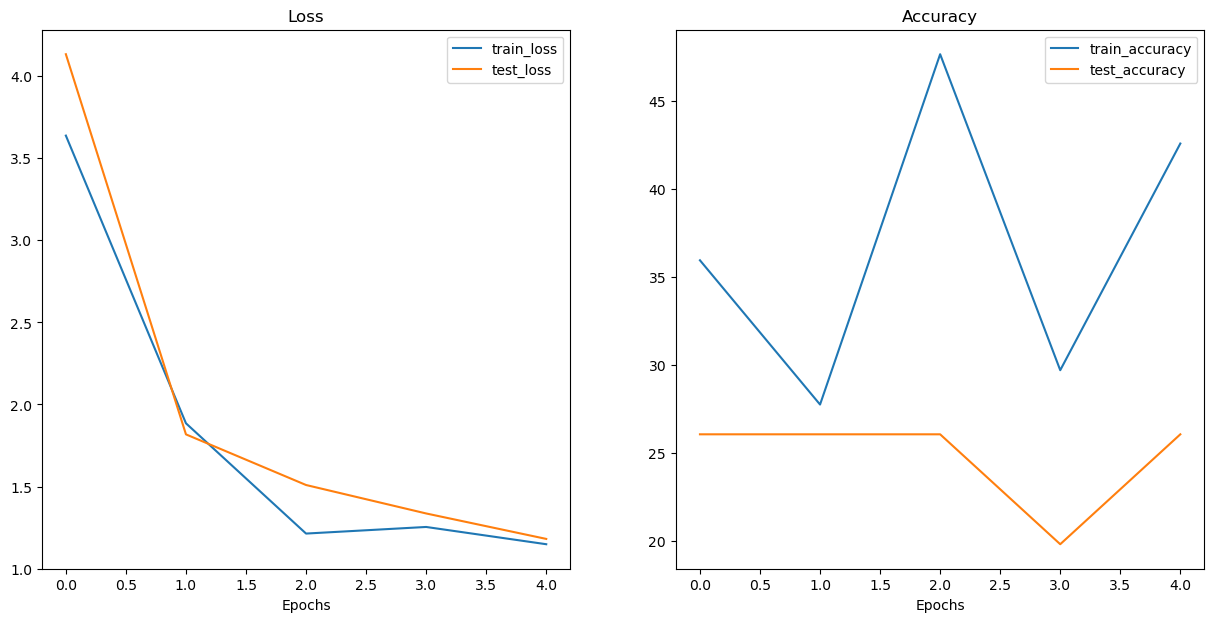

In [166]:
from ext_fns.helper_functions import plot_loss_curves

plot_loss_curves(results)

We can see that the loss is heading in the right direction, therefore by performing the above things, we too will be able to get good accurate results.

# using pretrained ViT base model
We will use this model to check the accuracy, inorder to ensure that the above points are the reason for poor accuracy.

In [1]:
from torchvision.models import ViT_B_16_Weights, vit_b_16

In [51]:
# 1. pretrained weights
vit_wts_pretrained = ViT_B_16_Weights.DEFAULT # default gives best possible output

# 2. Setup a ViT model instance
vit_pretrained = vit_b_16(weights=vit_wts_pretrained).to(device)

# 3. Freeze the base parameters
for parameter in vit_pretrained.parameters():
    parameter.requires_grad = False

vit_pretrained.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [52]:
summary(model=vit_pretrained,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width =20,
        input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [64, 3, 224, 224]    [64, 3]              768                  Partial
├─Conv2d: 1-1                                 [64, 3, 224, 224]    [64, 768, 14, 14]    (590,592)            False
├─Encoder: 1-2                                [64, 197, 768]       [64, 197, 768]       151,296              False
│    └─Dropout: 2-1                           [64, 197, 768]       [64, 197, 768]       --                   --
│    └─Sequential: 2-2                        [64, 197, 768]       [64, 197, 768]       --                   False
│    │    └─EncoderBlock: 3-1                 [64, 197, 768]       [64, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock: 3-2                 [64, 197, 768]       [64, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock: 3-3                 [64, 197, 768]       [64, 197, 

In [53]:
vit_transform = vit_wts_pretrained.transforms()
vit_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [54]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataset_dataloader(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transform,
                                                                                                     batch_size=64)
# Create optimizer and loss function
optim = torch.optim.Adam(params=vit_pretrained.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [55]:
torch.manual_seed(42)

pretrained_vit_results = engine.train(model=vit_pretrained,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optim,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)

 20%|████████████████▊                                                                   | 1/5 [00:22<01:30, 22.68s/it]

Model: VisionTransformer | train loss: 0.9152 | Train acc: 62.9380%
Model: VisionTransformer | Test loss: 0.7377, test accuracy: 83.8778409090909% 



 40%|█████████████████████████████████▌                                                  | 2/5 [00:45<01:08, 22.75s/it]

Model: VisionTransformer | train loss: 0.5437 | Train acc: 93.7737%
Model: VisionTransformer | Test loss: 0.5269, test accuracy: 84.01988636363637% 



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:07<00:44, 22.31s/it]

Model: VisionTransformer | train loss: 0.3481 | Train acc: 96.4844%
Model: VisionTransformer | Test loss: 0.4021, test accuracy: 84.01988636363637% 



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:29<00:22, 22.11s/it]

Model: VisionTransformer | train loss: 0.2547 | Train acc: 95.7505%
Model: VisionTransformer | Test loss: 0.3124, test accuracy: 88.5653409090909% 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:52<00:00, 22.50s/it]

Model: VisionTransformer | train loss: 0.1994 | Train acc: 96.8987%
Model: VisionTransformer | Test loss: 0.2594, test accuracy: 88.5653409090909% 



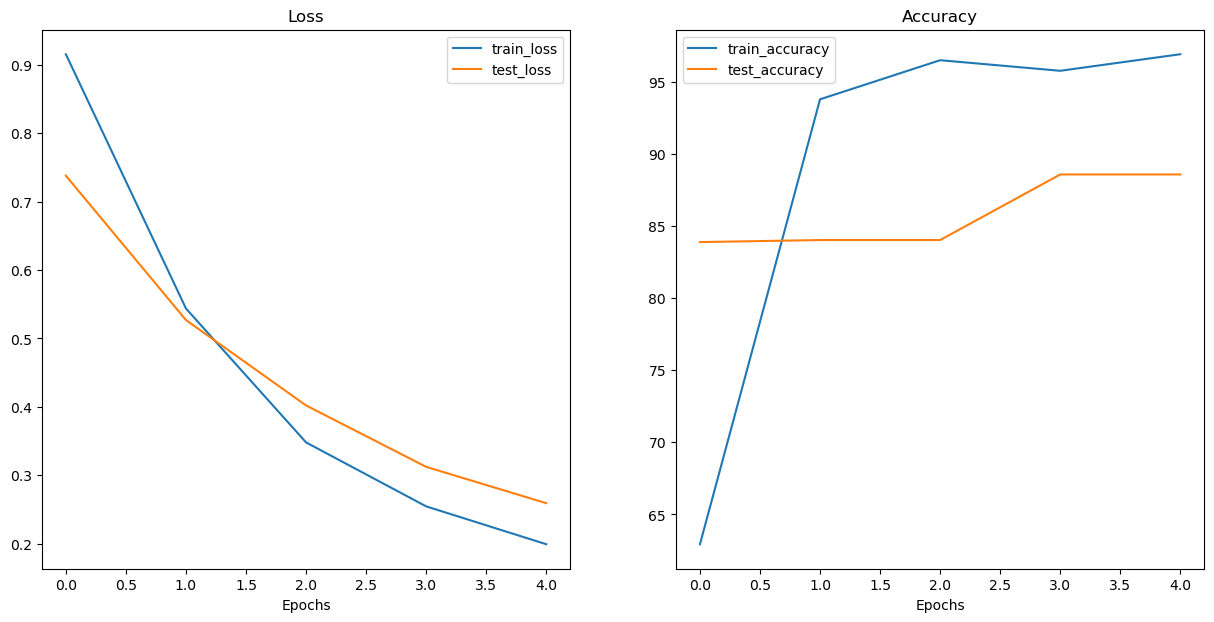

In [56]:
from ext_fns.helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

We can see the power of transfer learning, just by implementing a model of same architecture which was trained using ImageNet Dataset, we are able tyo achieve very high accuracy.

# 6. Save Model

In [57]:
from turning_modular import utils

utils.save_model(model=vit_pretrained,
                 target_dir="models",
                 model_name="08_ViT_paper_replication.pth")

Saving model ...


# 7. Model Prediction

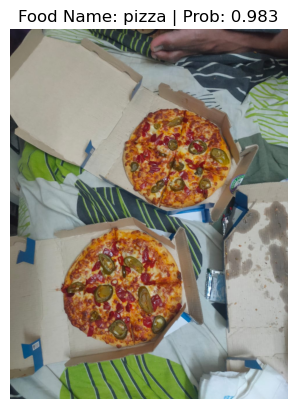

In [58]:
from PIL import Image

# open image
img = Image.open(data_path / "pizza_test_dominos.jpg")


# # predict the image

# make sure model is in target device
vit_pretrained.to(device)

# put in evaluation and inference mode
vit_pretrained.eval()
with torch.inference_mode():

    # transformed image
    transformed_image = vit_transform(img).unsqueeze(dim=0) # since expects to be in batches

    # prediction
    img_pred = vit_pretrained(transformed_image.to(device))

    # logits -> probability
    img_prob = torch.softmax(img_pred, dim=1)

    # probability -> prediction label
    img_label = torch.argmax(img_prob, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Food Name: {class_names[img_label]} | Prob: {img_prob.max():.3f}")
    plt.axis(False);

We can see that the model is now very certain that the food is `pizza`